# Store Item Demand Forecasting

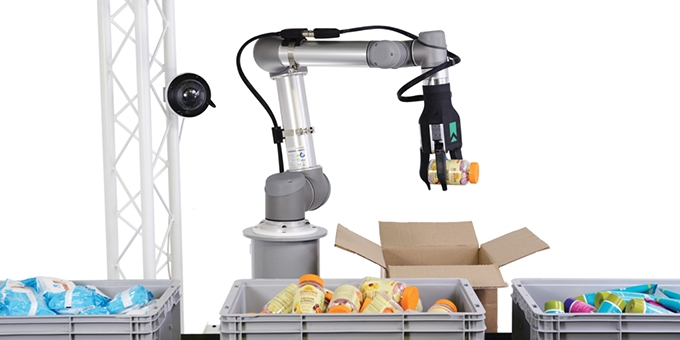

You probably have seen a lot of **Store-Item Demand Forecasting** notebooks in Kaggle; and you probably would like to search for a more specific, scrutinized in details and supported with unique functions. **Yeap you're in the right place**! Take a tour and find out detailed explanation and quick answers to possible requests.

**What is Time Series Analysis?**

Time series analysis is a specific way of analyzing a sequence of data collected.

What sets time series data apart from other data is that the analysis can show how variables change over time. So that means time is a crucial variable because it shows how the data adjusts over the course of the data. It provides an additional source of information and a set order of dependencies between the data.

**What is Machine Learning from Time Series?**

Machine learning methods offer a lot of promise for time series forecasting, such as the automatic learning of temporal dependence and the automatic handling of temporal structures like level, trends and seasonality.

This notebook uses **Microsoft's LightGBM and SMAPE** - Symmetric mean absolute percentage error (adjusted MAPE) as metric to custom cost function.

# Dataset story

There are two datasets: **demand_forecasting_train** and **demand_forecasting_test**

Columns of demand_forecasting_train dataset: date, store, item, sales

Columns of demand_forecasting_train dataset: id, date, store, item

So as you can see the train part doesn't consist id's (as there's no need for that column) and test part doesn't consist sales (as they will be predicted).

**What is about the dataset?**

This dataset includes 5 year sale datas of 50 different items of 10 different stores of a company.

**What is our task? What can be done?**

There is a lot of things we can do with that data, but this notebook will be predicting 3 months of sales looking only in the **item basis**, only in the **store basis** and also looking together in the **specified item-store basis**.



# Libraries & Dataset

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
from matplotlib.dates import date2num
import seaborn as sns
import lightgbm as lgb
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 1000)
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv('../input/demand-forecasting-kernels-only/train.csv', parse_dates=['date'])
test = pd.read_csv('../input/demand-forecasting-kernels-only/test.csv', parse_dates=['date'])
df = pd.concat([train, test], sort=False)

In [ ]:
df.head()

# Exploratory Data Analysis

In [ ]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(f"Rows: {dataframe.shape[0]}")
    print(f"Columns: {dataframe.shape[1]}")
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("####################### NA ######################")
    print(dataframe.isnull().sum())
    print("################### Quantiles ###################")
    print(dataframe.describe(percentiles=[0, 0.05, 0.50, 0.75, 0.95, 0.99]).T)
    print("##################### Head ######################")
    print(dataframe.head())


check_df(df)

In [ ]:
print("Dataset starts at: ",df["date"].min()," date and end at ",df["date"].max()," date.")

**Which is the highest sale value among all sales?**

In [ ]:
df[df["sales"] == df["sales"].max()]

**But, which PERIOD OF TIME (day, week, month...) was the most profitable (considering all product and item sales)?**

In [ ]:
def period_profitable(period="D", plot=False):

    df_perio = train.copy()
    df_perio.set_index("date", inplace=True)
    df_perio = df_perio.resample(period, closed='left').sum()
    df_perio.drop(columns=["store", "item"], inplace=True)
    df_perio["growth_rate"] = df_perio["sales"].pct_change() * 100
    df_perio.loc[[df_perio.index.min(), df_perio.index.max()], 'growth_rate'] = 0
    print(df_perio["sales"][df_perio["sales"] == df_perio["sales"].max()])

    if plot:
        df_perio["growth_rate"].plot(color="k", figsize=(12,8))
        plt.title(f"{period}'s growth rate")
        plt.xlabel("Date")
        plt.ylabel("Growth Rate %")
        plt.show()

    return df_perio

**Most profitable DAY of dataset:**

In [ ]:
df_day = period_profitable("D")

**Most profitable QUARTER of dataset:**

In [ ]:
df_quarter = period_profitable("Q")

**Let's find which week was the most profitable and how actually weekly growth rates compare to previous week sales performance:**

In [ ]:
df_week = period_profitable("W", True)

**So as we can see, weekly growth rates compared to previous week sales performance are losing the volatility. This implicit in the stabilization of our company sales, predictability of future sales and financial trust.**

# Feature Engineering

As we'll be using time series's features for machine learning, we'll should be generating new features to rise machine's success.

In the very first step, we'll be generating features based on datetime variable. This will help us find the **seasonality** in time series.

In [ ]:
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df

df = create_date_features(df)

**Now before generating lag or shifted variables, we should generate a series of random numbers as a "noise factor" for the lagged variables.**

**Why does RANDOM NOISE matters?**

Random Noise will help us predict while **conserving the randomity** of the variable. That means we'll be generating puppet variables which imitates the base variable **BUT NOT NECESSARILY PORTRAITS IT**.

In [ ]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe)))

random_df = random_noise(df)
random_df[0:5]

**Lagged/Shifted variables**

In [ ]:
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)


def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe


df = lag_features(df, [30, 91, 98, 105, 112, 119, 126, 182, 273, 364, 546, 728, 912, 1095])

**Rolling Mean Features**

In [ ]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(dataframe)
    return dataframe


df = roll_mean_features(df, [91, 182, 273, 365, 546, 728])

**Exponentially Weighted Mean Features**

In [ ]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


alphas = [0.99, 0.95, 0.9, 0.85, 0.8, 0.7, 0.6, 0.5]
lags = [30, 91, 98, 105, 112, 119, 126, 182, 273, 364, 546, 728, 912, 1095]

df = ewm_features(df, alphas, lags)

# One-Hot Encoding

In [ ]:
df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])

df.head()

**Converting sales to log(1+sales):**

In [ ]:
df['sales'] = np.log1p(df["sales"].values)

# Model

**Custom Cost Functions:**

In [ ]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

**Now we need first to predict sales of a period of time which actually we have datas of it. This process is called "valdation process" which is very much needed for the final result.**

**So because we have to predict first 3 months of 2018 year, we should validate our models success with the sales datas of first 3 months of the previous year, so 2017.**

In [ ]:
train = df.loc[(df["date"] < "2017-01-01"), :]
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]
cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]
Y_train = train['sales']
X_train = train[cols]
Y_val = val['sales']
X_val = val[cols]

**LightGBM Model**

In [ ]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1500,
              'early_stopping_rounds': 300,
              'nthread': -1}



lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=300)

**Predicted (log) sales values of validation dataset:**

In [ ]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
y_pred_val[0:5]

**The error percentage between real and predicted values is % 13.66 as below:**

In [ ]:
smape(np.expm1(y_pred_val), np.expm1(Y_val))

# Final Model

In [ ]:
train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]
test = df.loc[df.sales.isna()]
X_test = test[cols]

lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}


lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)

test_preds = model.predict(X_test, num_iteration=model.best_iteration)

**Importance of variables**

In [ ]:
def plot_lgb_importances(model, plot=False, list_num=10, plot_num=25):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:plot_num])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(list_num))

In [ ]:
plot_lgb_importances(model, list_num=10)

**Above we can see the list of vairables sorted by value of gain (importance) to explain the pattern within dataset.**

**Split column shows the number of times the variable took place while branching.**

**Please find below the plot of the list:**

In [ ]:
plot_lgb_importances(model, plot=True, plot_num=20)

# SPECIAL FUNCTION

In [ ]:
def product_forecast(only_store=False, only_store_plot=False,
                     only_item=False, only_item_plot=False,
                     store_item=False, store_item_plot=False, store="store_4", item="item_24", period="MS"):

    if only_store:
        df_test_preds = pd.DataFrame(test_preds, columns=["sales"])
        df["sales"].fillna(df_test_preds["sales"], inplace=True)
        df_item = df[df[store]==1]
        df_item['sales'] = np.expm1(df_item['sales'])
        df_item.set_index("date", inplace=True)
        df_item = df_item.resample(period).sum()
        df_item = df_item["sales"]

        if only_store_plot:
         fig, ax = plt.subplots(figsize=(12, 6))
         ax.plot(df_item.index, df_item, color="r")
         ax.axvspan(date2num(datetime(2018, 1, 1)), date2num(datetime(2018, 3, 31)),
                    label="Prediction", color="navy", alpha=0.3)
         ax.legend()
         ax.set_xlabel("Date")
         ax.set_ylabel('Amount')
         ax.set_title(f"{store}'s sales forecast for all items")
         plt.grid(axis="both")
         plt.tight_layout()
         plt.show()





    if only_item:
        df_test_preds = pd.DataFrame(test_preds, columns=["sales"])
        df["sales"].fillna(df_test_preds["sales"], inplace=True)
        df_item = df[df[item]==1]
        df_item['sales'] = np.expm1(df_item['sales'])
        df_item.set_index("date", inplace=True)
        df_item = df_item.resample(period).sum()
        df_item = df_item["sales"]

        if only_item_plot:
         fig, ax = plt.subplots(figsize=(12, 6))
         ax.plot(df_item.index, df_item, color="r")
         ax.axvspan(date2num(datetime(2018, 1, 1)), date2num(datetime(2018, 3, 31)),
                    label="Prediction", color="navy", alpha=0.3)
         ax.legend()
         ax.set_xlabel("Date")
         ax.set_ylabel('Amount')
         ax.set_title(f"{item}'s sales forecast for all stores")
         plt.grid(axis="both")
         plt.tight_layout()
         plt.show()





    if store_item:
        df_test_preds = pd.DataFrame(test_preds, columns=["sales"])
        df["sales"].fillna(df_test_preds["sales"], inplace=True)
        df_item = df[(df[store]==1) & (df[item]==1)]
        df_item['sales'] = np.expm1(df_item['sales'])
        df_item.set_index("date", inplace=True)
        df_item = df_item.resample(period).sum()
        df_item = df_item["sales"]

        if store_item_plot:
         fig, ax = plt.subplots(figsize=(12, 6))
         ax.plot(df_item.index, df_item, color="r")
         ax.axvspan(date2num(datetime(2018, 1, 1)), date2num(datetime(2018, 3, 31)),
                    label="Prediction", color="navy", alpha=0.3)
         ax.legend()
         ax.set_xlabel("Date")
         ax.set_ylabel('Amount')
         ax.set_title(f"{item}'s sales forecast at {store}")
         plt.grid(axis="both")
         plt.tight_layout()
         plt.show()


    return df_item

**Analyzing store_4'th sales forecast for all items in Weekly (W) basis:**

In [ ]:
store_4_W = product_forecast(only_store=True, only_store_plot=True, store="store_4", period="W")

**Analyzing item_21's sales forecast for all stores in Daily (D) basis:**

In [ ]:
item_21_D = product_forecast(only_item=True, only_item_plot=True, item="item_21", period="D")

**Analyzing item_32's sales forecast at store_3 in Monthly (M) basis:**

In [ ]:
store_3_item_32_M = product_forecast(store_item=True, store_item_plot=True, store="store_3", item="item_32", period="M")

**So the function will work in every analysis case in item, store and time basis.**

**This work has been done with the support of** [VBO](https://www.veribilimiokulu.com/) **&** [Miuul](https://miuul.com/).